# Load Spike Shape Models

In [1]:
using Revise,CSV,FileIO,Tables
shapes = [Tables.columns(CSV.File("spikeshapes.csv",datarow=1,allowmissing=:auto,transpose=true))...];

# Supervised Learning with Simulated Data

In [2]:
using Flux
model=load("dnn.jld2","model")

loaded


Chain(Dense(256, 256, NNlib.σ), Dense(256, 128, NNlib.relu), Dense(128, 48, NNlib.elu), Dense(48, 48, NNlib.elu), Recur(LSTMCell(48, 32)), Dense(32, 32, NNlib.σ), Dense(32, 16, NNlib.relu))

In [188]:
model = Chain(Dense(256,256,relu),Dense(256,128,relu),Dense(128,1024,relu),Dense(1024,48,relu),Dense(48,32,relu),Dense(32,32,relu),Dense(32,16,relu))

Chain(Dense(256, 256, NNlib.relu), Dense(256, 2048, NNlib.relu), Dense(2048, 48, NNlib.relu), Dense(48, 32, NNlib.relu), Dense(32, 32, NNlib.relu), Dense(32, 16, NNlib.relu))

## Training Model

In [449]:
using StatsBase,SpikeSorting,Dates,Plots,DataStructures,Statistics
function supervisedtrain!(model,spikeshapes;maxunitn=3,spikelength=52,snr=5,batchsize=500,epochn=5,acceptloss=0.5,acceptnsuccess=5,
        loss=(x,y)->Flux.crossentropy(softmax(model(x)), y),optimiser = ADAM(params(model),0.0001),maxtrainmemory=50,callbacktimeout=60,
        maxtrytrain=100,lossbuffern=50,acceptminlossrate=0.01,maxnewtry=30)
    
    Flux.truncate!(model);Flux.reset!(model)
    starttime=now();nnewtry=0
    inputn = size(params(model)[1],2);outputn = size(params(model)[end],1)
    nsuccesspredict=0;ntrain=0;ntrainmemory=0;ntraintry=0;losses=CircularBuffer{Float64}(lossbuffern)
    # train with 1,2,3,... number of units
    for nu in 1:maxunitn
        @info "Train $nu unit spikes ..."
        while true
            units = sample(spikeshapes,nu,replace=false)
            nnewtry+=1
            uid = rand(1:nu,batchsize)
            spike = hcat((spikeshape(1:spikelength,units[uid[i]]...,snr=snr) for i in 1:batchsize)...)
            t,x=resample(spike,inputn)
            y = Flux.onehotbatch(uid,1:outputn)
            if loss(x,y) < acceptloss
                nsuccesspredict+=1
                if nsuccesspredict >= acceptnsuccess
                    @info "success predict consecutive $acceptnsuccess new dataset"
                    break
                end
            else
                if nnewtry>maxnewtry
                    @info "stop after failing predict $nnewtry new dataset"
                    nnewtry=0
                    break
                end
                nsuccesspredict=0
                while true
                    for epoch in 1:epochn
                        Flux.train!(loss, [(x,y)], optimiser,cb=Flux.throttle(()->@show(loss(x,y)),callbacktimeout))
                        ntrain+=1;ntrainmemory+=1;ntraintry+=1
                    end
                    l = loss(x,y)
                    if l < acceptloss
                        @info "success training with loss: $l <= $acceptloss"
                        Flux.truncate!(model)
                        ntrainmemory=0
                        ntraintry=0
                        empty!(losses)
                        Flux.reset!(model)
                        break
                    end
                    push!(losses,Tracker.data(l))
                    if length(losses)==lossbuffern
                        mlr = abs(mean(diff(losses)))
                        if mlr<acceptminlossrate
                            @info "stop after mean last $lossbuffern loss rate: $mlr < $acceptminlossrate"
                            Flux.truncate!(model)
                            ntrainmemory=0
                            ntraintry=0
                            empty!(losses)
                            Flux.reset!(model)
                            display(plotsorting(t,x,uid,Flux.onecold(model(x),1:outputn)))
                            break
                        end
                    end
                    if ntraintry>maxtrytrain
                        @info "stop after $ntraintry training with loss: $l > $acceptloss"
                        Flux.truncate!(model)
                        ntrainmemory=0
                        ntraintry=0
                        empty!(losses)
                        Flux.reset!(model)
                        display(plotsorting(t,x,uid,Flux.onecold(model(x),1:outputn)))
                        break
                    end
                    
                    if ntrainmemory>maxtrainmemory
                        Flux.truncate!(model)
                        ntrainmemory=0
                    end
                    uid = rand(1:nu,batchsize)
                    spike = hcat((spikeshape(1:spikelength,units[uid[i]]...,snr=snr) for i in 1:batchsize)...)
                    t,x=resample(spike,inputn)
                    y = Flux.onehotbatch(uid,1:outputn)
                end
            end
        end
    end
    @info "finished $ntrain training in $(round(now()-starttime,Dates.Minute(1)))"
end
function plotsorting(t,x,uid,û)
    p = plot(t,x,layout=(1,2),subplot=1,size=(900,350),color=unitscolor[uid'],legend=:none,link=:all,title="Ground Truth")
    plot!(p,t,x,subplot=2,color=unitscolor[û'],legend=:none,title="Model Prediction")
end

plotsorting (generic function with 1 method)

In [413]:
supervisedtrain!(model,shapes,maxunitn=4)

loss(x, y) = 7.073732367449085 (tracked)

┌ Info: Train 1 unit spikes ...
└ @ Main In[250]:12



loss(x, y) = 5.286685000336329 (tracked)
loss(x, y) = 3.601046244887538 (tracked)
loss(x, y) = 2.1244089714535765 (tracked)
loss(x, y) = 1.0196560214291657 (tracked)
loss(x, y) = 0.40459497658236315 (tracked)
loss(x, y) = 0.1387583927647499 (tracked)
loss(x, y) = 0.04957100437397597 (tracked)
loss(x, y) = 0.020934964119377425 (tracked)
loss(x, y) = 0.010697652256481319 (tracked)


┌ Info: success training with loss: 0.010697652256481319 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.2001120018135694 (tracked)
loss(x, y) = 1.1647067925522443 (tracked)
loss(x, y) = 1.1243464988371372 (tracked)
loss(x, y) = 1.0807521535399387 (tracked)
loss(x, y) = 1.0350221845469338 (tracked)
loss(x, y) = 0.9908531711759067 (tracked)
loss(x, y) = 0.9439160208164826 (tracked)
loss(x, y) = 0.897224350888503 (tracked)
loss(x, y) = 0.8511836517136375 (tracked)
loss(x, y) = 0.8062455353551682 (tracked)
loss(x, y) = 0.7622556936301174 (tracked)
loss(x, y) = 0.7201228331054174 (tracked)
loss(x, y) = 0.6796609777393735 (tracked)
loss(x, y) = 0.6407833915115682 (tracked)
loss(x, y) = 0.6033049821871967 (tracked)
loss(x, y) = 0.5661554336244747 (tracked)
loss(x, y) = 0.5311273533756271 (tracked)
loss(x, y) = 0.49720610908992635 (tracked)
loss(x, y) = 0.4642704512796575 (tracked)
loss(x, y) = 0.43217289640665685 (tracked)


┌ Info: success training with loss: 0.43217289640665685 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.5217552493665194 (tracked)
loss(x, y) = 0.41198286660274275 (tracked)
loss(x, y) = 0.31020824795861285 (tracked)
loss(x, y) = 0.2290790986300431 (tracked)
loss(x, y) = 0.17130737463439305 (tracked)


┌ Info: success training with loss: 0.17130737463439305 (tracked) <= 0.5
└ @ Main In[250]:40
┌ Info: success predict consecutive 5 new dataset
└ @ Main In[250]:23
┌ Info: Train 2 unit spikes ...
└ @ Main In[250]:12


loss(x, y) = 1.7718052033542777 (tracked)
loss(x, y) = 1.6316521368199517 (tracked)
loss(x, y) = 1.465067940176659 (tracked)
loss(x, y) = 1.2900185764927523 (tracked)
loss(x, y) = 1.118467211119807 (tracked)
loss(x, y) = 1.0065530450209481 (tracked)
loss(x, y) = 0.8560227757433222 (tracked)
loss(x, y) = 0.7212660251119967 (tracked)
loss(x, y) = 0.6064467023803939 (tracked)
loss(x, y) = 0.5124522354038165 (tracked)
loss(x, y) = 0.4281969399145661 (tracked)
loss(x, y) = 0.37060925581664556 (tracked)
loss(x, y) = 0.32440272937641135 (tracked)
loss(x, y) = 0.28740681390109507 (tracked)
loss(x, y) = 0.2574049877438607 (tracked)


┌ Info: success training with loss: 0.2574049877438607 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.815024487701119 (tracked)
loss(x, y) = 0.718484433747992 (tracked)
loss(x, y) = 0.6105887915183935 (tracked)
loss(x, y) = 0.49952632361352617 (tracked)
loss(x, y) = 0.39842129376483887 (tracked)


┌ Info: success training with loss: 0.39842129376483887 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.6336906252848824 (tracked)
loss(x, y) = 1.4886391057013184 (tracked)
loss(x, y) = 1.3050898056370999 (tracked)
loss(x, y) = 1.0964968763944944 (tracked)
loss(x, y) = 0.8743412363726647 (tracked)
loss(x, y) = 0.6490858399288854 (tracked)
loss(x, y) = 0.4561103348631782 (tracked)
loss(x, y) = 0.30694231197134764 (tracked)
loss(x, y) = 0.2059115916663109 (tracked)
loss(x, y) = 0.14432862182968403 (tracked)


┌ Info: success training with loss: 0.14432862182968403 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.6788308500456874 (tracked)
loss(x, y) = 1.6006005958137608 (tracked)
loss(x, y) = 1.4871131370360586 (tracked)
loss(x, y) = 1.343867116808579 (tracked)
loss(x, y) = 1.176622314580819 (tracked)
loss(x, y) = 0.8797035437826387 (tracked)
loss(x, y) = 0.7042069677243201 (tracked)
loss(x, y) = 0.536100390714976 (tracked)
loss(x, y) = 0.3889875194973955 (tracked)
loss(x, y) = 0.26977103563354604 (tracked)


┌ Info: success training with loss: 0.26977103563354604 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.6634013153553797 (tracked)
loss(x, y) = 1.545064642624779 (tracked)
loss(x, y) = 1.3824342225160686 (tracked)
loss(x, y) = 1.1918197356072675 (tracked)
loss(x, y) = 0.9879975317618194 (tracked)
loss(x, y) = 0.7286987013406714 (tracked)
loss(x, y) = 0.570902412817872 (tracked)
loss(x, y) = 0.43738749219741035 (tracked)
loss(x, y) = 0.3308489159102684 (tracked)
loss(x, y) = 0.24886856401960003 (tracked)


┌ Info: success training with loss: 0.24886856401960003 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.8103001837002689 (tracked)
loss(x, y) = 0.6982477286397093 (tracked)
loss(x, y) = 0.5683086559675649 (tracked)
loss(x, y) = 0.4410527814193783 (tracked)
loss(x, y) = 0.3318770681361757 (tracked)


┌ Info: success training with loss: 0.3318770681361757 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.6698731690605633 (tracked)
loss(x, y) = 1.543069597496502 (tracked)
loss(x, y) = 1.38974567440812 (tracked)
loss(x, y) = 1.2259470264424386 (tracked)
loss(x, y) = 1.0588625206775997 (tracked)
loss(x, y) = 0.7850859800256625 (tracked)
loss(x, y) = 0.641562286534564 (tracked)
loss(x, y) = 0.4998682515929112 (tracked)
loss(x, y) = 0.37111027548063463 (tracked)
loss(x, y) = 0.27913045143836823 (tracked)


┌ Info: success training with loss: 0.27913045143836823 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.5157333713479773 (tracked)
loss(x, y) = 0.4558339711463742 (tracked)
loss(x, y) = 0.40099044338228623 (tracked)
loss(x, y) = 0.3528662071287391 (tracked)
loss(x, y) = 0.31050576540330094 (tracked)


┌ Info: success training with loss: 0.31050576540330094 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.8394067612465798 (tracked)
loss(x, y) = 0.8270349367984632 (tracked)
loss(x, y) = 0.8073885554642718 (tracked)
loss(x, y) = 0.7820149427467552 (tracked)
loss(x, y) = 0.7524109506721325 (tracked)
loss(x, y) = 0.7039267810555705 (tracked)
loss(x, y) = 0.6700860105781737 (tracked)
loss(x, y) = 0.6357868673985878 (tracked)
loss(x, y) = 0.6015482527966022 (tracked)
loss(x, y) = 0.5680357644662517 (tracked)
loss(x, y) = 0.524906827248408 (tracked)
loss(x, y) = 0.49561255848781804 (tracked)
loss(x, y) = 0.46840299611079894 (tracked)
loss(x, y) = 0.4428919014393228 (tracked)
loss(x, y) = 0.4190941696577203 (tracked)


┌ Info: success training with loss: 0.4190941696577203 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.5484980486754713 (tracked)
loss(x, y) = 0.4781660589683404 (tracked)
loss(x, y) = 0.403758883364412 (tracked)
loss(x, y) = 0.3365432540710995 (tracked)
loss(x, y) = 0.28225384085808164 (tracked)


┌ Info: success training with loss: 0.28225384085808164 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.6875551906045992 (tracked)
loss(x, y) = 0.5467067133183903 (tracked)
loss(x, y) = 0.4133676474085627 (tracked)
loss(x, y) = 0.31390083309764066 (tracked)
loss(x, y) = 0.25777914691950804 (tracked)


┌ Info: success training with loss: 0.25777914691950804 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.0957876879015827 (tracked)
loss(x, y) = 1.0101197647215927 (tracked)
loss(x, y) = 0.8877860843300659 (tracked)
loss(x, y) = 0.7518665904779769 (tracked)
loss(x, y) = 0.6266334987926713 (tracked)
loss(x, y) = 0.5431083790200213 (tracked)
loss(x, y) = 0.46763578531825806 (tracked)
loss(x, y) = 0.41487081555893157 (tracked)
loss(x, y) = 0.3706636208866045 (tracked)
loss(x, y) = 0.32890679424051084 (tracked)


┌ Info: success training with loss: 0.32890679424051084 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.5826570341617499 (tracked)
loss(x, y) = 0.4350968013047283 (tracked)
loss(x, y) = 0.3024304683901754 (tracked)
loss(x, y) = 0.20697895928710716 (tracked)
loss(x, y) = 0.14643508172793077 (tracked)


┌ Info: success training with loss: 0.14643508172793077 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.1832210391386815 (tracked)
loss(x, y) = 1.1797518910889726 (tracked)
loss(x, y) = 1.1637955605900006 (tracked)
loss(x, y) = 1.137218027706168 (tracked)
loss(x, y) = 1.1012980867801394 (tracked)
loss(x, y) = 0.9915583617772029 (tracked)
loss(x, y) = 0.945335142464894 (tracked)
loss(x, y) = 0.8949229524267851 (tracked)
loss(x, y) = 0.842646177293259 (tracked)
loss(x, y) = 0.7902700118094256 (tracked)
loss(x, y) = 0.7965753438698866 (tracked)
loss(x, y) = 0.7361695592498597 (tracked)
loss(x, y) = 0.6681736175357744 (tracked)
loss(x, y) = 0.5915205732904413 (tracked)
loss(x, y) = 0.51844563745169 (tracked)
loss(x, y) = 0.45660736227371607 (tracked)
loss(x, y) = 0.4197692582416231 (tracked)
loss(x, y) = 0.3887113336181532 (tracked)
loss(x, y) = 0.36083494932641624 (tracked)
loss(x, y) = 0.33577637133658417 (tracked)


┌ Info: success training with loss: 0.33577637133658417 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.3227165843948043 (tracked)
loss(x, y) = 3.0226938077704015 (tracked)
loss(x, y) = 2.6322218644615343 (tracked)
loss(x, y) = 2.1959031711636445 (tracked)
loss(x, y) = 1.7429993219681381 (tracked)
loss(x, y) = 1.290693292064078 (tracked)
loss(x, y) = 0.9023789786267935 (tracked)
loss(x, y) = 0.5950156911456423 (tracked)
loss(x, y) = 0.39732577190665175 (tracked)
loss(x, y) = 0.2963784110491015 (tracked)


┌ Info: success training with loss: 0.2963784110491015 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.8359964105749476 (tracked)
loss(x, y) = 0.7696992853665537 (tracked)
loss(x, y) = 0.7206945316484539 (tracked)
loss(x, y) = 0.6881336874959167 (tracked)
loss(x, y) = 0.6681878821255103 (tracked)
loss(x, y) = 0.6557510789507981 (tracked)
loss(x, y) = 0.6529292932974958 (tracked)
loss(x, y) = 0.6473945880754038 (tracked)
loss(x, y) = 0.6352427479670726 (tracked)
loss(x, y) = 0.6144297462872919 (tracked)
loss(x, y) = 0.5997395258805598 (tracked)
loss(x, y) = 0.5622762535878393 (tracked)
loss(x, y) = 0.520130177869898 (tracked)
loss(x, y) = 0.4757966851928319 (tracked)
loss(x, y) = 0.43178656140472005 (tracked)


┌ Info: success training with loss: 0.43178656140472005 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.8680976890431227 (tracked)
loss(x, y) = 0.8305382692688159 (tracked)
loss(x, y) = 0.7842495666333389 (tracked)
loss(x, y) = 0.7335354894676847 (tracked)
loss(x, y) = 0.6826788797217517 (tracked)
loss(x, y) = 0.6401579394749892 (tracked)
loss(x, y) = 0.5968528575653577 (tracked)
loss(x, y) = 0.5587425000532069 (tracked)
loss(x, y) = 0.5249928100487955 (tracked)
loss(x, y) = 0.4935207980191235 (tracked)


┌ Info: success training with loss: 0.4935207980191235 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.7945034370382875 (tracked)
loss(x, y) = 3.469580790990281 (tracked)
loss(x, y) = 3.076340771853229 (tracked)
loss(x, y) = 2.649993443019898 (tracked)
loss(x, y) = 2.243208369453997 (tracked)
loss(x, y) = 2.1549270458016134 (tracked)
loss(x, y) = 1.686844956251929 (tracked)
loss(x, y) = 1.2315976135015807 (tracked)
loss(x, y) = 0.8214130049704863 (tracked)
loss(x, y) = 0.510420415222917 (tracked)
loss(x, y) = 0.3442748798295801 (tracked)
loss(x, y) = 0.25503612201870374 (tracked)
loss(x, y) = 0.2107543841699121 (tracked)
loss(x, y) = 0.18967565091709196 (tracked)
loss(x, y) = 0.1770456922838211 (tracked)


┌ Info: success training with loss: 0.1770456922838211 (tracked) <= 0.5
└ @ Main In[250]:40
┌ Info: stop after failing predict 34 new dataset
└ @ Main In[250]:28
┌ Info: Train 3 unit spikes ...
└ @ Main In[250]:12


loss(x, y) = 5.614730918490522 (tracked)
loss(x, y) = 5.295344127307117 (tracked)
loss(x, y) = 4.851516196884232 (tracked)
loss(x, y) = 4.351425240126344 (tracked)
loss(x, y) = 3.896673824110557 (tracked)
loss(x, y) = 3.842961303167317 (tracked)
loss(x, y) = 3.459504819395491 (tracked)
loss(x, y) = 3.116723703901478 (tracked)
loss(x, y) = 2.792113183804686 (tracked)
loss(x, y) = 2.4905458926648394 (tracked)
loss(x, y) = 1.9343386262296594 (tracked)
loss(x, y) = 1.7155057693418783 (tracked)
loss(x, y) = 1.5176208918172154 (tracked)
loss(x, y) = 1.3453653356257773 (tracked)
loss(x, y) = 1.1908058694580748 (tracked)
loss(x, y) = 1.185292261289935 (tracked)
loss(x, y) = 1.0370520866204673 (tracked)
loss(x, y) = 0.9023860460542423 (tracked)
loss(x, y) = 0.7831555694704594 (tracked)
loss(x, y) = 0.6804125739724076 (tracked)
loss(x, y) = 0.5732690782114421 (tracked)
loss(x, y) = 0.5013276712540018 (tracked)
loss(x, y) = 0.43836896245240903 (tracked)
loss(x, y) = 0.3856276811378015 (tracked)
l

┌ Info: success training with loss: 0.34462840260322697 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.9594275054274771 (tracked)
loss(x, y) = 0.9039279881809973 (tracked)
loss(x, y) = 0.8426047885208243 (tracked)
loss(x, y) = 0.7794764219698961 (tracked)
loss(x, y) = 0.7168335003174745 (tracked)
loss(x, y) = 0.6482273646033003 (tracked)
loss(x, y) = 0.5909139372725708 (tracked)
loss(x, y) = 0.5380250277084406 (tracked)
loss(x, y) = 0.4901702832297733 (tracked)
loss(x, y) = 0.44664923781641036 (tracked)


┌ Info: success training with loss: 0.44664923781641036 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.0834602970144793 (tracked)
loss(x, y) = 1.038522074136506 (tracked)
loss(x, y) = 0.9834552303254616 (tracked)
loss(x, y) = 0.922773400131209 (tracked)
loss(x, y) = 0.8596995114624901 (tracked)
loss(x, y) = 0.8027000729193052 (tracked)
loss(x, y) = 0.7342361861359946 (tracked)
loss(x, y) = 0.6664571637492664 (tracked)
loss(x, y) = 0.6014027111552537 (tracked)
loss(x, y) = 0.5467020525425608 (tracked)
loss(x, y) = 0.5165560561406007 (tracked)
loss(x, y) = 0.48739723506448707 (tracked)
loss(x, y) = 0.46361773101322024 (tracked)
loss(x, y) = 0.44197345445710673 (tracked)
loss(x, y) = 0.42132192494335874 (tracked)


┌ Info: success training with loss: 0.42132192494335874 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.5039908213885617 (tracked)
loss(x, y) = 0.4838297963117311 (tracked)
loss(x, y) = 0.46115342927813946 (tracked)
loss(x, y) = 0.4366967510676691 (tracked)
loss(x, y) = 0.4111613660280943 (tracked)


┌ Info: success training with loss: 0.4111613660280943 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 4.22907047923651 (tracked)
loss(x, y) = 3.8208411965662936 (tracked)
loss(x, y) = 3.3101136200046604 (tracked)
loss(x, y) = 2.7247897280726128 (tracked)
loss(x, y) = 2.0856066105416775 (tracked)
loss(x, y) = 1.4916516033739031 (tracked)
loss(x, y) = 0.8237237854232841 (tracked)
loss(x, y) = 0.4797021278660991 (tracked)
loss(x, y) = 0.4684599568724302 (tracked)
loss(x, y) = 0.5342290189786197 (tracked)
loss(x, y) = 0.6253448897044305 (tracked)
loss(x, y) = 0.6783801284512405 (tracked)
loss(x, y) = 0.7166671246900835 (tracked)
loss(x, y) = 0.7411262328476542 (tracked)
loss(x, y) = 0.7532208678850464 (tracked)
loss(x, y) = 0.8004815719024034 (tracked)
loss(x, y) = 0.7915629630698682 (tracked)
loss(x, y) = 0.7740650128185812 (tracked)
loss(x, y) = 0.7491836027602574 (tracked)
loss(x, y) = 0.7181803701524259 (tracked)
loss(x, y) = 0.5937715109971408 (tracked)
loss(x, y) = 0.5606358470275092 (tracked)
loss(x, y) = 0.5256026800116939 (tracked)
loss(x, y) = 0.4894346501665137 (tra

┌ Info: success training with loss: 0.4528856619029733 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.610534118441155 (tracked)
loss(x, y) = 1.5313798459689505 (tracked)
loss(x, y) = 1.4189364032849257 (tracked)
loss(x, y) = 1.2891993935588288 (tracked)
loss(x, y) = 1.1616032180133482 (tracked)
loss(x, y) = 1.0730139269160777 (tracked)
loss(x, y) = 1.0319160177822173 (tracked)
loss(x, y) = 0.9981166027753026 (tracked)
loss(x, y) = 0.9665991464884028 (tracked)
loss(x, y) = 0.9407510439911115 (tracked)
loss(x, y) = 0.929825820637003 (tracked)
loss(x, y) = 0.9145662533053064 (tracked)
loss(x, y) = 0.9002380732124556 (tracked)
loss(x, y) = 0.8861101698704523 (tracked)
loss(x, y) = 0.8720681728005856 (tracked)
loss(x, y) = 0.8332077732577767 (tracked)
loss(x, y) = 0.819741370046709 (tracked)
loss(x, y) = 0.806418590944191 (tracked)
loss(x, y) = 0.7932796634361744 (tracked)
loss(x, y) = 0.7803480121373371 (tracked)
loss(x, y) = 0.825604357864798 (tracked)
loss(x, y) = 0.8118098223099448 (tracked)
loss(x, y) = 0.7980616552089062 (tracked)
loss(x, y) = 0.7843639347508735 (tracke

┌ Info: success training with loss: 0.4818912758914574 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.2988395549899443 (tracked)
loss(x, y) = 2.2144966696241917 (tracked)
loss(x, y) = 2.101654987817382 (tracked)
loss(x, y) = 1.966905790076295 (tracked)
loss(x, y) = 1.8157135309116057 (tracked)
loss(x, y) = 1.678554556890834 (tracked)
loss(x, y) = 1.5073467328102326 (tracked)
loss(x, y) = 1.3318379684097068 (tracked)
loss(x, y) = 1.162694953304739 (tracked)
loss(x, y) = 1.019990511241124 (tracked)
loss(x, y) = 0.8537560175890615 (tracked)
loss(x, y) = 0.7757795213457269 (tracked)
loss(x, y) = 0.7285960859869044 (tracked)
loss(x, y) = 0.7017857486624058 (tracked)
loss(x, y) = 0.6858525654774692 (tracked)
loss(x, y) = 0.7081718883573745 (tracked)
loss(x, y) = 0.7000900666835442 (tracked)
loss(x, y) = 0.68514942640311 (tracked)
loss(x, y) = 0.6597598583800243 (tracked)
loss(x, y) = 0.623896415955907 (tracked)
loss(x, y) = 0.5720841208722304 (tracked)
loss(x, y) = 0.5228315216972794 (tracked)
loss(x, y) = 0.4752901246318679 (tracked)
loss(x, y) = 0.4340412839995279 (tracked)


┌ Info: success training with loss: 0.4005208495940681 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.8501663817203573 (tracked)
loss(x, y) = 3.5779020302293576 (tracked)
loss(x, y) = 3.2306524868661253 (tracked)
loss(x, y) = 2.816540696757713 (tracked)
loss(x, y) = 2.3518755611972195 (tracked)
loss(x, y) = 1.8518314112357999 (tracked)
loss(x, y) = 1.5459133188975798 (tracked)
loss(x, y) = 1.4543385710819416 (tracked)
loss(x, y) = 1.4193772013368058 (tracked)
loss(x, y) = 1.3713275628824364 (tracked)
loss(x, y) = 1.2958956363590464 (tracked)
loss(x, y) = 1.2059061930555284 (tracked)
loss(x, y) = 1.135780665258984 (tracked)
loss(x, y) = 1.0825149036373891 (tracked)
loss(x, y) = 1.0426946370782593 (tracked)
loss(x, y) = 0.9817167917864604 (tracked)
loss(x, y) = 0.9703758655388038 (tracked)
loss(x, y) = 0.9591748149445021 (tracked)
loss(x, y) = 0.9453157207036766 (tracked)
loss(x, y) = 0.9287814566844725 (tracked)
loss(x, y) = 1.0331320295627848 (tracked)
loss(x, y) = 1.0096302233134138 (tracked)
loss(x, y) = 0.9842264983501223 (tracked)
loss(x, y) = 0.9576999352933202 (tra

┌ Info: success training with loss: 0.4091305381257237 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.1062752581916904 (tracked)
loss(x, y) = 1.937968198711477 (tracked)
loss(x, y) = 1.7228398977559194 (tracked)
loss(x, y) = 1.4978072939560843 (tracked)
loss(x, y) = 1.2639346843948678 (tracked)
loss(x, y) = 1.09662087836678 (tracked)
loss(x, y) = 0.9751464647513685 (tracked)
loss(x, y) = 0.8969141029430343 (tracked)
loss(x, y) = 0.8317074383332563 (tracked)
loss(x, y) = 0.7864566346895451 (tracked)
loss(x, y) = 0.7234219925165756 (tracked)
loss(x, y) = 0.662614896267179 (tracked)
loss(x, y) = 0.6067565467061613 (tracked)
loss(x, y) = 0.5572498128279285 (tracked)
loss(x, y) = 0.5126154151184763 (tracked)
loss(x, y) = 0.46573077775438115 (tracked)
loss(x, y) = 0.418173590222676 (tracked)
loss(x, y) = 0.371033972156131 (tracked)
loss(x, y) = 0.32722621829739773 (tracked)


┌ Info: success training with loss: 0.32722621829739773 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.303966933232081 (tracked)
loss(x, y) = 1.219178889766753 (tracked)
loss(x, y) = 1.1141811707482552 (tracked)
loss(x, y) = 1.0037099611270157 (tracked)
loss(x, y) = 0.8999746820821269 (tracked)
loss(x, y) = 0.882106478135358 (tracked)
loss(x, y) = 0.8215703449313062 (tracked)
loss(x, y) = 0.7842146326808404 (tracked)
loss(x, y) = 0.7631558280666236 (tracked)
loss(x, y) = 0.7484949929935096 (tracked)
loss(x, y) = 0.6517717163675226 (tracked)
loss(x, y) = 0.6412795823561217 (tracked)
loss(x, y) = 0.6310299047526603 (tracked)
loss(x, y) = 0.6205527218238456 (tracked)
loss(x, y) = 0.6098009680339619 (tracked)
loss(x, y) = 0.6222274343474252 (tracked)
loss(x, y) = 0.6106390675563267 (tracked)
loss(x, y) = 0.5987381520869318 (tracked)
loss(x, y) = 0.586594851189175 (tracked)
loss(x, y) = 0.5743409883706788 (tracked)
loss(x, y) = 0.5746705163174185 (tracked)
loss(x, y) = 0.5620360555341779 (tracked)
loss(x, y) = 0.5494724976089216 (tracked)
loss(x, y) = 0.5370241664312998 (track

┌ Info: success training with loss: 0.48606147864189564 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.6884558740121378 (tracked)
loss(x, y) = 1.1420055604550499 (tracked)
loss(x, y) = 0.7397541528107665 (tracked)
loss(x, y) = 0.5850596467641258 (tracked)
loss(x, y) = 0.5513650278926703 (tracked)
loss(x, y) = 0.5348929281724353 (tracked)
loss(x, y) = 0.515542167961731 (tracked)
loss(x, y) = 0.4915137553074302 (tracked)
loss(x, y) = 0.46984225784713407 (tracked)
loss(x, y) = 0.4553130966541055 (tracked)


┌ Info: success training with loss: 0.4553130966541055 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.8839396374335784 (tracked)
loss(x, y) = 1.8286019512052818 (tracked)
loss(x, y) = 1.768095054086892 (tracked)
loss(x, y) = 1.703489698957751 (tracked)
loss(x, y) = 1.6339862178263775 (tracked)
loss(x, y) = 1.5282262618804523 (tracked)
loss(x, y) = 1.4542038522518483 (tracked)
loss(x, y) = 1.3821440193061116 (tracked)
loss(x, y) = 1.3142616073424749 (tracked)
loss(x, y) = 1.2530097467194423 (tracked)
loss(x, y) = 1.2307659557848656 (tracked)
loss(x, y) = 1.1775187004287408 (tracked)
loss(x, y) = 1.1276225931969717 (tracked)
loss(x, y) = 1.0833960421854025 (tracked)
loss(x, y) = 1.0451842383500398 (tracked)
loss(x, y) = 1.0058616234558178 (tracked)
loss(x, y) = 0.9820101377277443 (tracked)
loss(x, y) = 0.9607246245577243 (tracked)
loss(x, y) = 0.9406183075035268 (tracked)
loss(x, y) = 0.9208543470391212 (tracked)
loss(x, y) = 0.9141207650098417 (tracked)
loss(x, y) = 0.8944752049322789 (tracked)
loss(x, y) = 0.8745821403642544 (tracked)
loss(x, y) = 0.8537957764917513 (tra

┌ Info: success training with loss: 0.4441075924790804 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.8396383182570398 (tracked)
loss(x, y) = 0.8036694725836387 (tracked)
loss(x, y) = 0.7639478374143548 (tracked)
loss(x, y) = 0.7258370447012926 (tracked)
loss(x, y) = 0.6911646061628282 (tracked)
loss(x, y) = 0.6473880647017313 (tracked)
loss(x, y) = 0.6193337147282791 (tracked)
loss(x, y) = 0.594098411474429 (tracked)
loss(x, y) = 0.5707278079792079 (tracked)
loss(x, y) = 0.5482406477369873 (tracked)
loss(x, y) = 0.5865484904302056 (tracked)
loss(x, y) = 0.5613471669320226 (tracked)
loss(x, y) = 0.5357063752031227 (tracked)
loss(x, y) = 0.5099038814503845 (tracked)
loss(x, y) = 0.4841956156614394 (tracked)


┌ Info: success training with loss: 0.4841956156614394 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.8805757710324208 (tracked)
loss(x, y) = 0.828631120878915 (tracked)
loss(x, y) = 0.756614215475193 (tracked)
loss(x, y) = 0.6761209654068778 (tracked)
loss(x, y) = 0.601905574219808 (tracked)
loss(x, y) = 0.5457797665751952 (tracked)
loss(x, y) = 0.4937030899707311 (tracked)
loss(x, y) = 0.4501324736859222 (tracked)
loss(x, y) = 0.4137278967325704 (tracked)
loss(x, y) = 0.3830730081096815 (tracked)
loss(x, y) = 0.8011592808726677 (tracked)


┌ Info: success training with loss: 0.3830730081096815 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.7472245555754425 (tracked)
loss(x, y) = 0.6892178072108959 (tracked)
loss(x, y) = 0.6309123676142374 (tracked)
loss(x, y) = 0.573201770058528 (tracked)
loss(x, y) = 0.5143185313311508 (tracked)
loss(x, y) = 0.4643580724298465 (tracked)
loss(x, y) = 0.4231779449159701 (tracked)
loss(x, y) = 0.3929248212450884 (tracked)
loss(x, y) = 0.37227002736087644 (tracked)


┌ Info: success training with loss: 0.37227002736087644 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.1169177101179468 (tracked)
loss(x, y) = 1.0559782408421001 (tracked)
loss(x, y) = 0.9765795280752371 (tracked)
loss(x, y) = 0.8853512949431664 (tracked)
loss(x, y) = 0.7870780602849591 (tracked)
loss(x, y) = 0.6344005235694665 (tracked)
loss(x, y) = 0.5399670043503263 (tracked)
loss(x, y) = 0.45680230619406254 (tracked)
loss(x, y) = 0.38817614261287825 (tracked)
loss(x, y) = 0.3362221532311387 (tracked)


┌ Info: success training with loss: 0.3362221532311387 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.273647280786921 (tracked)
loss(x, y) = 2.8328370385881114 (tracked)
loss(x, y) = 2.27908402083405 (tracked)
loss(x, y) = 1.658491464632578 (tracked)
loss(x, y) = 1.101326694341451 (tracked)
loss(x, y) = 0.7196376874790726 (tracked)
loss(x, y) = 0.609892823893048 (tracked)
loss(x, y) = 0.5958539528847143 (tracked)
loss(x, y) = 0.6062620574863312 (tracked)
loss(x, y) = 0.6123039443671373 (tracked)
loss(x, y) = 0.5874617071465075 (tracked)
loss(x, y) = 0.5641875276069251 (tracked)
loss(x, y) = 0.5311930342157823 (tracked)
loss(x, y) = 0.4914514815535799 (tracked)
loss(x, y) = 0.4488682515121881 (tracked)


┌ Info: success training with loss: 0.4488682515121881 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.8967780938318094 (tracked)
loss(x, y) = 0.8894992545317023 (tracked)
loss(x, y) = 0.8675895545644474 (tracked)
loss(x, y) = 0.8323231755181919 (tracked)
loss(x, y) = 0.7860786858782682 (tracked)
loss(x, y) = 0.6969959343490169 (tracked)
loss(x, y) = 0.6437199903450197 (tracked)
loss(x, y) = 0.5896217511822918 (tracked)
loss(x, y) = 0.5379460634794336 (tracked)
loss(x, y) = 0.49352762799372146 (tracked)


┌ Info: success training with loss: 0.49352762799372146 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.1414466649027983 (tracked)
loss(x, y) = 2.0627015384699554 (tracked)
loss(x, y) = 1.9582411984255292 (tracked)
loss(x, y) = 1.8389090784688362 (tracked)
loss(x, y) = 1.7142913443202215 (tracked)
loss(x, y) = 1.6490872489806976 (tracked)
loss(x, y) = 1.5240342135260423 (tracked)
loss(x, y) = 1.4026104483967679 (tracked)
loss(x, y) = 1.2848516323445123 (tracked)
loss(x, y) = 1.1722536634634744 (tracked)
loss(x, y) = 1.028295858123457 (tracked)
loss(x, y) = 0.9396325698930688 (tracked)
loss(x, y) = 0.8644203191080203 (tracked)
loss(x, y) = 0.8009974655397765 (tracked)
loss(x, y) = 0.7477327794108019 (tracked)
loss(x, y) = 0.7854718001204305 (tracked)
loss(x, y) = 0.7481488687602721 (tracked)
loss(x, y) = 0.7193673703145582 (tracked)
loss(x, y) = 0.6971587661911367 (tracked)
loss(x, y) = 0.6795275695134448 (tracked)
loss(x, y) = 0.6571949673605249 (tracked)
loss(x, y) = 0.6438522075426245 (tracked)
loss(x, y) = 0.6314395874241142 (tracked)
loss(x, y) = 0.6195530539891526 (tr

┌ Info: success training with loss: 0.47864799136994196 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.6949048516906378 (tracked)
loss(x, y) = 2.5757112796520376 (tracked)
loss(x, y) = 2.4102154886149574 (tracked)
loss(x, y) = 2.2122357368369 (tracked)
loss(x, y) = 1.9977661109751856 (tracked)
loss(x, y) = 1.7890290324167877 (tracked)
loss(x, y) = 1.6081574206572673 (tracked)
loss(x, y) = 1.4458128863851833 (tracked)
loss(x, y) = 1.3027374872828312 (tracked)
loss(x, y) = 1.1852694429253252 (tracked)
loss(x, y) = 1.0452105105151188 (tracked)
loss(x, y) = 0.9739622356837704 (tracked)
loss(x, y) = 0.9147902615068483 (tracked)
loss(x, y) = 0.8665780801601225 (tracked)
loss(x, y) = 0.8281504040615351 (tracked)
loss(x, y) = 0.8187640463396592 (tracked)
loss(x, y) = 0.7820006902757619 (tracked)
loss(x, y) = 0.7472592500217117 (tracked)
loss(x, y) = 0.7145436428406872 (tracked)
loss(x, y) = 0.6835236199449926 (tracked)
loss(x, y) = 0.6415036608264738 (tracked)
loss(x, y) = 0.6139933127180588 (tracked)
loss(x, y) = 0.588624885720316 (tracked)
loss(x, y) = 0.5649556417512931 (track

┌ Info: success training with loss: 0.45856124992715375 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.614591777620206 (tracked)
loss(x, y) = 1.4844688206713026 (tracked)
loss(x, y) = 1.3201993955414746 (tracked)
loss(x, y) = 1.14228152759453 (tracked)
loss(x, y) = 0.9759567032082058 (tracked)
loss(x, y) = 0.8322055906960159 (tracked)
loss(x, y) = 0.7309388632557596 (tracked)
loss(x, y) = 0.6559119388111362 (tracked)
loss(x, y) = 0.6034502168928004 (tracked)
loss(x, y) = 0.5662539180479196 (tracked)
loss(x, y) = 0.5356935335965688 (tracked)
loss(x, y) = 0.49753658502150994 (tracked)
loss(x, y) = 0.45704164907161327 (tracked)
loss(x, y) = 0.4183026753342703 (tracked)
loss(x, y) = 0.385876269813959 (tracked)


┌ Info: success training with loss: 0.385876269813959 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.4384983106493556 (tracked)
loss(x, y) = 1.3180511634909715 (tracked)
loss(x, y) = 1.1213081672071112 (tracked)
loss(x, y) = 0.877421553582549 (tracked)
loss(x, y) = 0.6330623199470902 (tracked)
loss(x, y) = 0.4305629082748974 (tracked)
loss(x, y) = 0.33095758152409804 (tracked)
loss(x, y) = 0.2940095369810551 (tracked)
loss(x, y) = 0.25795181289204616 (tracked)
loss(x, y) = 0.21059938338604564 (tracked)


┌ Info: success training with loss: 0.21059938338604564 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.9426330191584096 (tracked)
loss(x, y) = 0.9066690425418961 (tracked)
loss(x, y) = 0.8563847336553901 (tracked)
loss(x, y) = 0.7945282804628517 (tracked)
loss(x, y) = 0.7250908373333695 (tracked)
loss(x, y) = 0.6459326969114877 (tracked)
loss(x, y) = 0.5873906060826473 (tracked)
loss(x, y) = 0.5444352449903168 (tracked)
loss(x, y) = 0.506975445957533 (tracked)
loss(x, y) = 0.4706145943358682 (tracked)


┌ Info: success training with loss: 0.4706145943358682 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.695841037164541 (tracked)
loss(x, y) = 1.6425161683524407 (tracked)
loss(x, y) = 1.5697902483883768 (tracked)
loss(x, y) = 1.4766267763551342 (tracked)
loss(x, y) = 1.362862053894576 (tracked)
loss(x, y) = 1.2664740131744952 (tracked)
loss(x, y) = 1.096736465148241 (tracked)
loss(x, y) = 0.925936850536416 (tracked)
loss(x, y) = 0.7827560786382344 (tracked)
loss(x, y) = 0.6884057820109851 (tracked)
loss(x, y) = 0.6701225369239845 (tracked)
loss(x, y) = 0.6166755938100624 (tracked)
loss(x, y) = 0.5686748686208891 (tracked)
loss(x, y) = 0.5229494480595785 (tracked)
loss(x, y) = 0.47786046839377105 (tracked)


┌ Info: success training with loss: 0.47786046839377105 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.2725621223506944 (tracked)
loss(x, y) = 1.2243176924948633 (tracked)
loss(x, y) = 1.1636739890634693 (tracked)
loss(x, y) = 1.0972398661564011 (tracked)
loss(x, y) = 1.0308601712668475 (tracked)
loss(x, y) = 1.0392413752202256 (tracked)
loss(x, y) = 0.9804420837112903 (tracked)
loss(x, y) = 0.9282955619976749 (tracked)
loss(x, y) = 0.8817104534700013 (tracked)
loss(x, y) = 0.840096858198516 (tracked)
loss(x, y) = 0.7311779330934794 (tracked)
loss(x, y) = 0.6992681093903313 (tracked)
loss(x, y) = 0.6663224260757546 (tracked)
loss(x, y) = 0.6310484221378283 (tracked)
loss(x, y) = 0.5953091368658961 (tracked)
loss(x, y) = 0.6154021071400221 (tracked)
loss(x, y) = 0.5760146559079269 (tracked)
loss(x, y) = 0.536897452288924 (tracked)
loss(x, y) = 0.4986019343677244 (tracked)
loss(x, y) = 0.4610899507973696 (tracked)


┌ Info: success training with loss: 0.4610899507973696 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.1309161582454426 (tracked)
loss(x, y) = 2.864076628919399 (tracked)
loss(x, y) = 2.5780372381646073 (tracked)
loss(x, y) = 2.29782027044359 (tracked)
loss(x, y) = 2.0180848797262794 (tracked)
loss(x, y) = 1.7698302649103987 (tracked)
loss(x, y) = 1.5203711725098155 (tracked)
loss(x, y) = 1.294855208404576 (tracked)
loss(x, y) = 1.0982720309400222 (tracked)
loss(x, y) = 0.9313187508278018 (tracked)
loss(x, y) = 0.7708302041154137 (tracked)
loss(x, y) = 0.6577668246039012 (tracked)
loss(x, y) = 0.5652737641859553 (tracked)
loss(x, y) = 0.49644061010828944 (tracked)
loss(x, y) = 0.4585979889095321 (tracked)


┌ Info: success training with loss: 0.4585979889095321 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.3908479344392517 (tracked)
loss(x, y) = 1.3530423068378878 (tracked)
loss(x, y) = 1.2931057679235618 (tracked)
loss(x, y) = 1.2175599548349947 (tracked)
loss(x, y) = 1.1318218920432974 (tracked)
loss(x, y) = 1.010189568696733 (tracked)
loss(x, y) = 0.9216076011782653 (tracked)
loss(x, y) = 0.8339769961233438 (tracked)
loss(x, y) = 0.7501188850134957 (tracked)
loss(x, y) = 0.679282289142645 (tracked)
loss(x, y) = 0.6357353622497178 (tracked)
loss(x, y) = 0.5909318525305728 (tracked)
loss(x, y) = 0.5446462587732915 (tracked)
loss(x, y) = 0.49447705063186437 (tracked)
loss(x, y) = 0.44572435146184014 (tracked)


┌ Info: success training with loss: 0.44572435146184014 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.956009077076224 (tracked)
loss(x, y) = 1.239008834134149 (tracked)
loss(x, y) = 0.7188949659191013 (tracked)
loss(x, y) = 0.6560002294051658 (tracked)
loss(x, y) = 0.7798244343259902 (tracked)
loss(x, y) = 0.859581893748323 (tracked)
loss(x, y) = 0.8201923225119866 (tracked)
loss(x, y) = 0.6804312755750539 (tracked)
loss(x, y) = 0.5114750900037031 (tracked)
loss(x, y) = 0.39505136629957127 (tracked)


┌ Info: success training with loss: 0.39505136629957127 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.6034155405375695 (tracked)
loss(x, y) = 0.5464728689099025 (tracked)
loss(x, y) = 0.5071678023118136 (tracked)
loss(x, y) = 0.48264424840543596 (tracked)
loss(x, y) = 0.4628424191858896 (tracked)


┌ Info: success training with loss: 0.4628424191858896 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.3217709500763395 (tracked)
loss(x, y) = 0.911487122216023 (tracked)
loss(x, y) = 0.5407925823307632 (tracked)
loss(x, y) = 0.3892218685487194 (tracked)
loss(x, y) = 0.339238835867344 (tracked)


┌ Info: success training with loss: 0.339238835867344 (tracked) <= 0.5
└ @ Main In[250]:40
┌ Info: stop after failing predict 31 new dataset
└ @ Main In[250]:28
┌ Info: Train 4 unit spikes ...
└ @ Main In[250]:12


loss(x, y) = 8.386335475459012 (tracked)
loss(x, y) = 7.2973077073805435 (tracked)
loss(x, y) = 6.25398607934967 (tracked)
loss(x, y) = 5.088335667316451 (tracked)
loss(x, y) = 4.040443151679685 (tracked)
loss(x, y) = 3.337595249417186 (tracked)
loss(x, y) = 2.9694685464447024 (tracked)
loss(x, y) = 2.924143440330001 (tracked)
loss(x, y) = 2.7147672638931732 (tracked)
loss(x, y) = 2.2874153052300628 (tracked)
loss(x, y) = 1.9750497436768308 (tracked)
loss(x, y) = 1.7859083346282714 (tracked)
loss(x, y) = 1.5817185456670204 (tracked)
loss(x, y) = 1.3569841692511233 (tracked)
loss(x, y) = 1.1297308461362487 (tracked)
loss(x, y) = 0.9549040481878287 (tracked)
loss(x, y) = 0.7983951027009755 (tracked)
loss(x, y) = 0.6953939528545656 (tracked)
loss(x, y) = 0.6455946803744124 (tracked)
loss(x, y) = 0.6251291227733551 (tracked)
loss(x, y) = 0.6227578871736248 (tracked)
loss(x, y) = 0.6133722126263328 (tracked)
loss(x, y) = 0.595640317847758 (tracked)
loss(x, y) = 0.5718878031722572 (tracked)


┌ Info: success training with loss: 0.3955714906671367 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.876383520866203 (tracked)
loss(x, y) = 3.6974292095969408 (tracked)
loss(x, y) = 3.4782419177410158 (tracked)
loss(x, y) = 3.2353416663497794 (tracked)
loss(x, y) = 2.985089431916059 (tracked)
loss(x, y) = 2.7478342747400677 (tracked)
loss(x, y) = 2.5093438151818472 (tracked)
loss(x, y) = 2.2852934999126653 (tracked)
loss(x, y) = 2.0737066947682377 (tracked)
loss(x, y) = 1.8724895599783569 (tracked)
loss(x, y) = 1.608697946133238 (tracked)
loss(x, y) = 1.4543246336833144 (tracked)
loss(x, y) = 1.314657557084128 (tracked)
loss(x, y) = 1.1836618853031686 (tracked)
loss(x, y) = 1.0585709700941859 (tracked)
loss(x, y) = 0.8992693308636395 (tracked)
loss(x, y) = 0.786493411339367 (tracked)
loss(x, y) = 0.691572806252138 (tracked)
loss(x, y) = 0.6316017351194693 (tracked)
loss(x, y) = 0.5950990351844707 (tracked)
loss(x, y) = 0.613806891816347 (tracked)
loss(x, y) = 0.586872121965763 (tracked)
loss(x, y) = 0.561214838453911 (tracked)
loss(x, y) = 0.5352257812588676 (tracked)
l

┌ Info: success training with loss: 0.3681558764630843 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.7851915737799877 (tracked)
loss(x, y) = 1.7163435766226403 (tracked)
loss(x, y) = 1.6557036738688224 (tracked)
loss(x, y) = 1.5860969550547133 (tracked)
loss(x, y) = 1.513284610837035 (tracked)
loss(x, y) = 1.468142508633223 (tracked)
loss(x, y) = 1.3952688932697566 (tracked)
loss(x, y) = 1.3264450917880681 (tracked)
loss(x, y) = 1.261454891251755 (tracked)
loss(x, y) = 1.2005586395214787 (tracked)
loss(x, y) = 1.1583895151268788 (tracked)
loss(x, y) = 1.1053914172177615 (tracked)
loss(x, y) = 1.0545393328829213 (tracked)
loss(x, y) = 1.0061975266495993 (tracked)
loss(x, y) = 0.9600373899656156 (tracked)
loss(x, y) = 0.9418924863270375 (tracked)
loss(x, y) = 0.8981972505422091 (tracked)
loss(x, y) = 0.8518360833476746 (tracked)
loss(x, y) = 0.8037090976672339 (tracked)
loss(x, y) = 0.7595133302195614 (tracked)
loss(x, y) = 0.7364401065683548 (tracked)
loss(x, y) = 0.7109737670073467 (tracked)
loss(x, y) = 0.6852009614107277 (tracked)
loss(x, y) = 0.6569283017261974 (trac

┌ Info: success training with loss: 0.4546529684833897 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.80989589627083 (tracked)
loss(x, y) = 2.5713331688682146 (tracked)
loss(x, y) = 2.3279555150830253 (tracked)
loss(x, y) = 2.0498140762638557 (tracked)
loss(x, y) = 1.733873521069926 (tracked)
loss(x, y) = 1.4361580047159523 (tracked)
loss(x, y) = 1.079285035999092 (tracked)
loss(x, y) = 0.8316937787496127 (tracked)
loss(x, y) = 0.674704500780828 (tracked)
loss(x, y) = 0.5511513387058499 (tracked)
loss(x, y) = 0.45454430518111555 (tracked)
loss(x, y) = 0.3733300749612828 (tracked)
loss(x, y) = 0.3131402745366239 (tracked)
loss(x, y) = 0.2746037181066787 (tracked)
loss(x, y) = 0.2509536163330257 (tracked)


┌ Info: success training with loss: 0.2509536163330257 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.734298482864183 (tracked)
loss(x, y) = 3.3418753472641174 (tracked)
loss(x, y) = 2.827371984536249 (tracked)
loss(x, y) = 2.4268178723742477 (tracked)
loss(x, y) = 2.1893874113432554 (tracked)
loss(x, y) = 2.056544242000144 (tracked)
loss(x, y) = 1.899274674185493 (tracked)
loss(x, y) = 1.7463631442120393 (tracked)
loss(x, y) = 1.5587221986262598 (tracked)
loss(x, y) = 1.3373336871352794 (tracked)
loss(x, y) = 1.168494858456235 (tracked)
loss(x, y) = 1.0076969789821362 (tracked)
loss(x, y) = 0.8789074569733629 (tracked)
loss(x, y) = 0.7750264103848393 (tracked)
loss(x, y) = 0.7008521966841347 (tracked)
loss(x, y) = 0.6674069315166172 (tracked)
loss(x, y) = 0.6388171535387528 (tracked)
loss(x, y) = 0.611359205918168 (tracked)
loss(x, y) = 0.5771875509051191 (tracked)
loss(x, y) = 0.5360862588045148 (tracked)
loss(x, y) = 0.4720222028914795 (tracked)
loss(x, y) = 0.4295398804582194 (tracked)
loss(x, y) = 0.3904296764926173 (tracked)
loss(x, y) = 0.3559947511785027 (tracked

┌ Info: success training with loss: 0.3276176968786275 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.4708694161847509 (tracked)
loss(x, y) = 1.394971053109879 (tracked)
loss(x, y) = 1.2804193920360085 (tracked)
loss(x, y) = 1.140605243658033 (tracked)
loss(x, y) = 0.992353576453597 (tracked)
loss(x, y) = 0.845205483607582 (tracked)
loss(x, y) = 0.7290855729624804 (tracked)
loss(x, y) = 0.6383096212782169 (tracked)
loss(x, y) = 0.5723611958005262 (tracked)
loss(x, y) = 0.5197418901907986 (tracked)
loss(x, y) = 0.48472037182851646 (tracked)
loss(x, y) = 0.44617543376344154 (tracked)
loss(x, y) = 0.41490936725816974 (tracked)
loss(x, y) = 0.390228469956954 (tracked)
loss(x, y) = 0.36985605750226025 (tracked)


┌ Info: success training with loss: 0.36985605750226025 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.2406437555365697 (tracked)
loss(x, y) = 1.2043137855326633 (tracked)
loss(x, y) = 1.1630400641656622 (tracked)
loss(x, y) = 1.121424583628161 (tracked)
loss(x, y) = 1.0813578830003285 (tracked)
loss(x, y) = 1.1564843933402258 (tracked)
loss(x, y) = 1.121548958560545 (tracked)
loss(x, y) = 1.0848771769246515 (tracked)
loss(x, y) = 1.0477447619298474 (tracked)
loss(x, y) = 1.0096495658737614 (tracked)
loss(x, y) = 0.8789708165908885 (tracked)
loss(x, y) = 0.8402437735733848 (tracked)
loss(x, y) = 0.8011103582553698 (tracked)
loss(x, y) = 0.7625981650915409 (tracked)
loss(x, y) = 0.7250762852982107 (tracked)
loss(x, y) = 0.7357678931641922 (tracked)
loss(x, y) = 0.7001600111395127 (tracked)
loss(x, y) = 0.6654028240715779 (tracked)
loss(x, y) = 0.6317415640822264 (tracked)
loss(x, y) = 0.5986833038757725 (tracked)
loss(x, y) = 0.5596895630027966 (tracked)
loss(x, y) = 0.5308848448835085 (tracked)
loss(x, y) = 0.501691258758352 (tracked)
loss(x, y) = 0.4720984695067545 (trac

┌ Info: success training with loss: 0.4423853050274686 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.7290528202795277 (tracked)
loss(x, y) = 2.2830604768438505 (tracked)
loss(x, y) = 1.7505807652417598 (tracked)
loss(x, y) = 1.2781745485327414 (tracked)
loss(x, y) = 1.027315996012116 (tracked)
loss(x, y) = 0.9219932011194618 (tracked)
loss(x, y) = 0.8322374474823815 (tracked)
loss(x, y) = 0.7470798550989016 (tracked)
loss(x, y) = 0.6733099376197272 (tracked)
loss(x, y) = 0.6147182014674661 (tracked)
loss(x, y) = 0.5233156931406497 (tracked)
loss(x, y) = 0.491749052398864 (tracked)
loss(x, y) = 0.4657082306322632 (tracked)
loss(x, y) = 0.4425297133254531 (tracked)
loss(x, y) = 0.42103785003417843 (tracked)


┌ Info: success training with loss: 0.42103785003417843 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.1152941183711267 (tracked)
loss(x, y) = 1.0933445316301933 (tracked)
loss(x, y) = 1.065243887864752 (tracked)
loss(x, y) = 1.032443612525583 (tracked)
loss(x, y) = 0.9959797176537815 (tracked)
loss(x, y) = 0.9244710629406662 (tracked)
loss(x, y) = 0.8843493019690177 (tracked)
loss(x, y) = 0.8431906896042473 (tracked)
loss(x, y) = 0.8016183665689044 (tracked)
loss(x, y) = 0.7614003365944532 (tracked)
loss(x, y) = 0.7339827976898007 (tracked)
loss(x, y) = 0.6926552380848122 (tracked)
loss(x, y) = 0.6537412213712235 (tracked)
loss(x, y) = 0.6180345562218664 (tracked)
loss(x, y) = 0.5848299335731953 (tracked)
loss(x, y) = 0.5692330309014101 (tracked)
loss(x, y) = 0.5420001292258362 (tracked)
loss(x, y) = 0.5178005680851224 (tracked)
loss(x, y) = 0.49700511490056015 (tracked)
loss(x, y) = 0.47936133887743676 (tracked)


┌ Info: success training with loss: 0.47936133887743676 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.3270089962931206 (tracked)
loss(x, y) = 2.223623325350696 (tracked)
loss(x, y) = 2.0871703403402315 (tracked)
loss(x, y) = 1.9315893695443598 (tracked)
loss(x, y) = 1.7670648127124096 (tracked)
loss(x, y) = 1.5427221405417724 (tracked)
loss(x, y) = 1.3859600313965288 (tracked)
loss(x, y) = 1.241273185974081 (tracked)
loss(x, y) = 1.1162838163910256 (tracked)
loss(x, y) = 1.0095612333550497 (tracked)
loss(x, y) = 0.9371205747316318 (tracked)
loss(x, y) = 0.8447652618388362 (tracked)
loss(x, y) = 0.7624789322897564 (tracked)
loss(x, y) = 0.689039854389428 (tracked)
loss(x, y) = 0.6260186044040331 (tracked)
loss(x, y) = 0.5713725923410977 (tracked)
loss(x, y) = 0.5265482438924646 (tracked)
loss(x, y) = 0.4869012597277077 (tracked)
loss(x, y) = 0.4495366680971638 (tracked)
loss(x, y) = 0.41279032604144283 (tracked)


┌ Info: success training with loss: 0.41279032604144283 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.038088975831578 (tracked)
loss(x, y) = 2.758377051586156 (tracked)
loss(x, y) = 2.424942483407627 (tracked)
loss(x, y) = 2.1706059910902615 (tracked)
loss(x, y) = 1.9815532403159815 (tracked)
loss(x, y) = 1.8091233013823267 (tracked)
loss(x, y) = 1.6613200252268117 (tracked)
loss(x, y) = 1.5382997482835525 (tracked)
loss(x, y) = 1.4219600766703981 (tracked)
loss(x, y) = 1.2998820172470873 (tracked)
loss(x, y) = 1.2369592328691315 (tracked)
loss(x, y) = 1.1203543382746675 (tracked)
loss(x, y) = 1.0365331566494935 (tracked)
loss(x, y) = 0.982990393191093 (tracked)
loss(x, y) = 0.94336988607173 (tracked)
loss(x, y) = 0.8617463599263723 (tracked)
loss(x, y) = 0.823327754678437 (tracked)
loss(x, y) = 0.783636476984881 (tracked)
loss(x, y) = 0.7420696871666775 (tracked)
loss(x, y) = 0.6993772801762158 (tracked)
loss(x, y) = 0.6710862201753434 (tracked)
loss(x, y) = 0.6285593450173262 (tracked)
loss(x, y) = 0.5884010069716749 (tracked)
loss(x, y) = 0.5524729746959295 (tracked)


┌ Info: success training with loss: 0.4042867664372429 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.355657813759135 (tracked)
loss(x, y) = 1.2871871754439446 (tracked)
loss(x, y) = 1.199116454465951 (tracked)
loss(x, y) = 1.1009244928158788 (tracked)
loss(x, y) = 0.9989256610803408 (tracked)
loss(x, y) = 0.9201881256103908 (tracked)
loss(x, y) = 0.8199572119943253 (tracked)
loss(x, y) = 0.7192115277138433 (tracked)
loss(x, y) = 0.6193325544875817 (tracked)
loss(x, y) = 0.5244270034043805 (tracked)
loss(x, y) = 0.44740502571575896 (tracked)
loss(x, y) = 0.3723444819056486 (tracked)
loss(x, y) = 0.3111715880270913 (tracked)
loss(x, y) = 0.26150890300488144 (tracked)
loss(x, y) = 0.22076196377832072 (tracked)


┌ Info: success training with loss: 0.22076196377832072 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.4864748381199624 (tracked)
loss(x, y) = 1.2759392011574637 (tracked)
loss(x, y) = 1.0469123986154392 (tracked)
loss(x, y) = 0.8272517490915244 (tracked)
loss(x, y) = 0.6303869958806797 (tracked)
loss(x, y) = 0.4528477001930881 (tracked)
loss(x, y) = 0.30691886983169236 (tracked)
loss(x, y) = 0.19646569389290625 (tracked)
loss(x, y) = 0.13119043590516902 (tracked)
loss(x, y) = 0.09701856695300702 (tracked)


┌ Info: success training with loss: 0.09701856695300702 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 0.6078328330452514 (tracked)
loss(x, y) = 0.5377749283567514 (tracked)
loss(x, y) = 0.4491378796985464 (tracked)
loss(x, y) = 0.3590623255244128 (tracked)
loss(x, y) = 0.27904652025601123 (tracked)


┌ Info: success training with loss: 0.27904652025601123 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.396621973471811 (tracked)
loss(x, y) = 2.985521780863325 (tracked)
loss(x, y) = 2.4943881814975692 (tracked)
loss(x, y) = 2.0648435577752933 (tracked)
loss(x, y) = 1.7187260413460008 (tracked)
loss(x, y) = 1.473070805194031 (tracked)
loss(x, y) = 1.2752257643103826 (tracked)
loss(x, y) = 1.1017466969290404 (tracked)
loss(x, y) = 0.9395760516128152 (tracked)
loss(x, y) = 0.7899923234483189 (tracked)
loss(x, y) = 0.680421387837438 (tracked)
loss(x, y) = 0.5857670520585678 (tracked)
loss(x, y) = 0.5170003086283018 (tracked)
loss(x, y) = 0.4699327062178636 (tracked)
loss(x, y) = 0.4371616673711784 (tracked)


┌ Info: success training with loss: 0.4371616673711784 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.7315566510737064 (tracked)
loss(x, y) = 2.340581408871463 (tracked)
loss(x, y) = 1.8506610704189774 (tracked)
loss(x, y) = 1.4176632327271068 (tracked)
loss(x, y) = 1.1229878632338164 (tracked)
loss(x, y) = 0.8574733621103342 (tracked)
loss(x, y) = 0.6361046695407526 (tracked)
loss(x, y) = 0.44478754177387575 (tracked)
loss(x, y) = 0.29856521460623114 (tracked)
loss(x, y) = 0.199545410099842 (tracked)


┌ Info: success training with loss: 0.199545410099842 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.016492640886624 (tracked)
loss(x, y) = 2.684530603077067 (tracked)
loss(x, y) = 2.3348699637745987 (tracked)
loss(x, y) = 1.9881332738168083 (tracked)
loss(x, y) = 1.6792078809534796 (tracked)
loss(x, y) = 1.3486328265412495 (tracked)
loss(x, y) = 1.152368209678234 (tracked)
loss(x, y) = 0.9793675905380401 (tracked)
loss(x, y) = 0.831882786270654 (tracked)
loss(x, y) = 0.7127476923638449 (tracked)
loss(x, y) = 0.6420180258669566 (tracked)
loss(x, y) = 0.5501122931383192 (tracked)
loss(x, y) = 0.4693036550115229 (tracked)
loss(x, y) = 0.4006842521504102 (tracked)
loss(x, y) = 0.3400708210275717 (tracked)


┌ Info: success training with loss: 0.3400708210275717 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 4.406513136969691 (tracked)
loss(x, y) = 3.8662457325481463 (tracked)
loss(x, y) = 3.2587791226507528 (tracked)
loss(x, y) = 2.6477933470863064 (tracked)
loss(x, y) = 2.030597686025695 (tracked)
loss(x, y) = 1.4902080429269349 (tracked)
loss(x, y) = 1.1459570652781708 (tracked)
loss(x, y) = 0.9175711808960582 (tracked)
loss(x, y) = 0.7553487718510273 (tracked)
loss(x, y) = 0.620204735192502 (tracked)
loss(x, y) = 0.516157442743792 (tracked)
loss(x, y) = 0.4175133906612759 (tracked)
loss(x, y) = 0.336485989036411 (tracked)
loss(x, y) = 0.27270960548540496 (tracked)
loss(x, y) = 0.22339531047431985 (tracked)


┌ Info: success training with loss: 0.22339531047431985 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.6715520354004623 (tracked)
loss(x, y) = 3.1880251159734256 (tracked)
loss(x, y) = 2.5963880583187318 (tracked)
loss(x, y) = 1.9618682275145218 (tracked)
loss(x, y) = 1.41346778822966 (tracked)
loss(x, y) = 1.0512062198675405 (tracked)
loss(x, y) = 0.8750155820429002 (tracked)
loss(x, y) = 0.777791426095148 (tracked)
loss(x, y) = 0.7177875508738298 (tracked)
loss(x, y) = 0.6712555292140577 (tracked)
loss(x, y) = 0.5983010295900896 (tracked)
loss(x, y) = 0.5580666343822088 (tracked)
loss(x, y) = 0.5191707627084331 (tracked)
loss(x, y) = 0.4811892950192387 (tracked)
loss(x, y) = 0.444312233035533 (tracked)


┌ Info: success training with loss: 0.444312233035533 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 3.3837353824407916 (tracked)
loss(x, y) = 3.018839864019986 (tracked)
loss(x, y) = 2.5407346984590586 (tracked)
loss(x, y) = 2.016644601956795 (tracked)
loss(x, y) = 1.5965651402620291 (tracked)
loss(x, y) = 1.3511506797603905 (tracked)
loss(x, y) = 1.1884218862813858 (tracked)
loss(x, y) = 1.0716799414843026 (tracked)
loss(x, y) = 0.9741539494449355 (tracked)
loss(x, y) = 0.8834917189522484 (tracked)
loss(x, y) = 0.8063436459534437 (tracked)
loss(x, y) = 0.7254736846403491 (tracked)
loss(x, y) = 0.6531433118491909 (tracked)
loss(x, y) = 0.5903211069170898 (tracked)
loss(x, y) = 0.5380472444797738 (tracked)
loss(x, y) = 0.5115289892763503 (tracked)
loss(x, y) = 0.4772292643645791 (tracked)
loss(x, y) = 0.4482250197069816 (tracked)
loss(x, y) = 0.42231918193748264 (tracked)
loss(x, y) = 0.3977023839621567 (tracked)


┌ Info: success training with loss: 0.3977023839621567 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.3734575936732054 (tracked)
loss(x, y) = 1.0567064497528904 (tracked)
loss(x, y) = 0.8500252069217641 (tracked)
loss(x, y) = 0.7398422315027967 (tracked)
loss(x, y) = 0.667329077987907 (tracked)
loss(x, y) = 0.6471751134553394 (tracked)
loss(x, y) = 0.6031757987698914 (tracked)
loss(x, y) = 0.5692654317241156 (tracked)
loss(x, y) = 0.5415118020987519 (tracked)
loss(x, y) = 0.5187228880326451 (tracked)
loss(x, y) = 0.49228243936721783 (tracked)
loss(x, y) = 0.4769376327371156 (tracked)
loss(x, y) = 0.45882383298369456 (tracked)
loss(x, y) = 0.4372506491466208 (tracked)
loss(x, y) = 0.4123908182318506 (tracked)


┌ Info: success training with loss: 0.4123908182318506 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 4.156792558109629 (tracked)
loss(x, y) = 3.5617572703744664 (tracked)
loss(x, y) = 2.7726528588378514 (tracked)
loss(x, y) = 2.0058737020417166 (tracked)
loss(x, y) = 1.5265257379124917 (tracked)
loss(x, y) = 1.4047641577854393 (tracked)
loss(x, y) = 1.309909333346889 (tracked)
loss(x, y) = 1.24229558557815 (tracked)
loss(x, y) = 1.1835288759153246 (tracked)
loss(x, y) = 1.1298987420106708 (tracked)
loss(x, y) = 0.9568253125366709 (tracked)
loss(x, y) = 0.9117971008302149 (tracked)
loss(x, y) = 0.8677548037839864 (tracked)
loss(x, y) = 0.825142166382866 (tracked)
loss(x, y) = 0.7846001654367085 (tracked)
loss(x, y) = 0.7146075115134137 (tracked)
loss(x, y) = 0.6785914195019468 (tracked)
loss(x, y) = 0.6442609609382642 (tracked)
loss(x, y) = 0.6113381336348925 (tracked)
loss(x, y) = 0.5790687115057587 (tracked)
loss(x, y) = 0.6451847209049644 (tracked)
loss(x, y) = 0.6134315773739087 (tracked)
loss(x, y) = 0.5882130626069231 (tracked)
loss(x, y) = 0.5672709750883821 (tracke

┌ Info: success training with loss: 0.4407645886496475 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.270693419519862 (tracked)
loss(x, y) = 2.0863659729350723 (tracked)
loss(x, y) = 1.8683465166062643 (tracked)
loss(x, y) = 1.641315362249339 (tracked)
loss(x, y) = 1.42941714457469 (tracked)
loss(x, y) = 1.1104981742319209 (tracked)
loss(x, y) = 0.9874121164756703 (tracked)
loss(x, y) = 0.8976548708273719 (tracked)
loss(x, y) = 0.8380384277819315 (tracked)
loss(x, y) = 0.79421881137852 (tracked)
loss(x, y) = 0.860890037775961 (tracked)
loss(x, y) = 0.8188347117033784 (tracked)
loss(x, y) = 0.776603869308318 (tracked)
loss(x, y) = 0.7335290603281479 (tracked)
loss(x, y) = 0.6926888421306996 (tracked)
loss(x, y) = 0.6738626405208864 (tracked)
loss(x, y) = 0.6408968591662846 (tracked)
loss(x, y) = 0.6122567050258727 (tracked)
loss(x, y) = 0.5877452819011735 (tracked)
loss(x, y) = 0.5689388481012115 (tracked)
loss(x, y) = 0.5500131499539512 (tracked)
loss(x, y) = 0.5405266083087175 (tracked)
loss(x, y) = 0.5319951255954222 (tracked)
loss(x, y) = 0.5235946811975789 (tracked)


┌ Info: success training with loss: 0.4772143130907892 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.9803742065451835 (tracked)
loss(x, y) = 2.8100622401084796 (tracked)
loss(x, y) = 2.5947026214818125 (tracked)
loss(x, y) = 2.356643982690285 (tracked)
loss(x, y) = 2.114331271795467 (tracked)
loss(x, y) = 1.890250687006881 (tracked)
loss(x, y) = 1.6751681339164863 (tracked)
loss(x, y) = 1.4732198703826511 (tracked)
loss(x, y) = 1.2898247786463122 (tracked)
loss(x, y) = 1.1331777261596576 (tracked)
loss(x, y) = 1.0005044521350637 (tracked)
loss(x, y) = 0.8973475793547354 (tracked)
loss(x, y) = 0.8266197658337733 (tracked)
loss(x, y) = 0.7775372150471743 (tracked)
loss(x, y) = 0.735110012657344 (tracked)
loss(x, y) = 0.6951497161137975 (tracked)
loss(x, y) = 0.6635060685875676 (tracked)
loss(x, y) = 0.640001610118584 (tracked)
loss(x, y) = 0.6219616437004885 (tracked)
loss(x, y) = 0.6072845678839516 (tracked)
loss(x, y) = 0.6026652947878519 (tracked)
loss(x, y) = 0.5883698027700016 (tracked)
loss(x, y) = 0.5727243751595498 (tracked)
loss(x, y) = 0.5556906574276754 (tracke

┌ Info: success training with loss: 0.45023077968402136 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.3979988904295146 (tracked)
loss(x, y) = 1.2838223008306402 (tracked)
loss(x, y) = 1.1466863720666955 (tracked)
loss(x, y) = 1.0125631166942004 (tracked)
loss(x, y) = 0.8954423160232639 (tracked)
loss(x, y) = 0.7510669020256239 (tracked)
loss(x, y) = 0.673703665095489 (tracked)
loss(x, y) = 0.605654020667767 (tracked)
loss(x, y) = 0.5447133850201595 (tracked)
loss(x, y) = 0.49181847944475965 (tracked)
loss(x, y) = 1.493524006505188 (tracked)


┌ Info: success training with loss: 0.49181847944475965 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.4256755772223693 (tracked)
loss(x, y) = 1.348687431478631 (tracked)
loss(x, y) = 1.2808255717006862 (tracked)
loss(x, y) = 1.228985875802699 (tracked)
loss(x, y) = 1.196404428160389 (tracked)
loss(x, y) = 1.1469876630922182 (tracked)
loss(x, y) = 1.0940188446781678 (tracked)
loss(x, y) = 1.0377757032606554 (tracked)
loss(x, y) = 0.979060536147093 (tracked)
loss(x, y) = 0.9467598724088843 (tracked)
loss(x, y) = 0.8821342505743085 (tracked)
loss(x, y) = 0.8167532499868512 (tracked)
loss(x, y) = 0.7522176980482054 (tracked)
loss(x, y) = 0.6910250563513455 (tracked)
loss(x, y) = 0.6530438894120159 (tracked)
loss(x, y) = 0.6116232202603846 (tracked)
loss(x, y) = 0.5776681672980715 (tracked)
loss(x, y) = 0.5488882707472282 (tracked)
loss(x, y) = 0.5237228587468129 (tracked)
loss(x, y) = 0.4964221867666272 (tracked)
loss(x, y) = 0.480125271992869 (tracked)
loss(x, y) = 0.462270050562365 (tracked)
loss(x, y) = 0.44248692498797654 (tracked)
loss(x, y) = 0.4210730398380035 (tracke

┌ Info: success training with loss: 0.4210730398380035 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.4149404991526493 (tracked)
loss(x, y) = 1.3880529670081423 (tracked)
loss(x, y) = 1.349290845120748 (tracked)
loss(x, y) = 1.3000205453316716 (tracked)
loss(x, y) = 1.2429890540539004 (tracked)
loss(x, y) = 1.1860425317779724 (tracked)
loss(x, y) = 1.1266091378795573 (tracked)
loss(x, y) = 1.0693466995025585 (tracked)
loss(x, y) = 1.0154161038217193 (tracked)
loss(x, y) = 0.9668352880469803 (tracked)
loss(x, y) = 0.8998776118958824 (tracked)
loss(x, y) = 0.8620665564610793 (tracked)
loss(x, y) = 0.8282916994501405 (tracked)
loss(x, y) = 0.7975066135703871 (tracked)
loss(x, y) = 0.7687467344758929 (tracked)
loss(x, y) = 0.7068145734261341 (tracked)
loss(x, y) = 0.6812652868708216 (tracked)
loss(x, y) = 0.6565917405961561 (tracked)
loss(x, y) = 0.6325924090110799 (tracked)
loss(x, y) = 0.6092725957272467 (tracked)
loss(x, y) = 0.6196759018401572 (tracked)
loss(x, y) = 0.5973186179976404 (tracked)
loss(x, y) = 0.5757942453168868 (tracked)
loss(x, y) = 0.5547838397229825 (tr

┌ Info: success training with loss: 0.4496095122922867 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.4772655806978316 (tracked)
loss(x, y) = 2.323659284653128 (tracked)
loss(x, y) = 2.1346699056536322 (tracked)
loss(x, y) = 1.942958690103233 (tracked)
loss(x, y) = 1.771674015654149 (tracked)
loss(x, y) = 1.7425668893184625 (tracked)
loss(x, y) = 1.5874078681227268 (tracked)
loss(x, y) = 1.4298292599959064 (tracked)
loss(x, y) = 1.2713335401962231 (tracked)
loss(x, y) = 1.1211463562852655 (tracked)
loss(x, y) = 1.0069682860313256 (tracked)
loss(x, y) = 0.8905082778067859 (tracked)
loss(x, y) = 0.7898683946180717 (tracked)
loss(x, y) = 0.6999499237350483 (tracked)
loss(x, y) = 0.6174621903066048 (tracked)
loss(x, y) = 0.5313774695903914 (tracked)
loss(x, y) = 0.46998952654593734 (tracked)
loss(x, y) = 0.4166888025776128 (tracked)
loss(x, y) = 0.3708119543561801 (tracked)
loss(x, y) = 0.33372160071461726 (tracked)


┌ Info: success training with loss: 0.33372160071461726 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 1.1085936495303863 (tracked)
loss(x, y) = 0.9813642510672506 (tracked)
loss(x, y) = 0.8545504704793538 (tracked)
loss(x, y) = 0.763990726382229 (tracked)
loss(x, y) = 0.7042681829034858 (tracked)
loss(x, y) = 0.6114937415725956 (tracked)
loss(x, y) = 0.5619617515231987 (tracked)
loss(x, y) = 0.5218735348306137 (tracked)
loss(x, y) = 0.48665729746908215 (tracked)
loss(x, y) = 0.4556989634613814 (tracked)


┌ Info: success training with loss: 0.4556989634613814 (tracked) <= 0.5
└ @ Main In[250]:40


loss(x, y) = 2.5993588441994926 (tracked)
loss(x, y) = 2.3033674823353305 (tracked)
loss(x, y) = 1.9592925536314272 (tracked)
loss(x, y) = 1.6393784155108702 (tracked)
loss(x, y) = 1.3825646426200884 (tracked)
loss(x, y) = 1.2005231585082365 (tracked)
loss(x, y) = 1.0275627942756493 (tracked)
loss(x, y) = 0.902766292229857 (tracked)
loss(x, y) = 0.826436813726048 (tracked)
loss(x, y) = 0.7891556141541816 (tracked)
loss(x, y) = 0.7804648888017928 (tracked)
loss(x, y) = 0.775051146307773 (tracked)
loss(x, y) = 0.7499297445605594 (tracked)
loss(x, y) = 0.6983911997757941 (tracked)
loss(x, y) = 0.6255850110831114 (tracked)
loss(x, y) = 0.5291502350965266 (tracked)
loss(x, y) = 0.44850366871632386 (tracked)
loss(x, y) = 0.37970877036407136 (tracked)
loss(x, y) = 0.32550263295578685 (tracked)
loss(x, y) = 0.2840613083196282 (tracked)


┌ Info: success training with loss: 0.2840613083196282 (tracked) <= 0.5
└ @ Main In[250]:40
┌ Info: stop after failing predict 31 new dataset
└ @ Main In[250]:28
┌ Info: finished 1385 training in 12 minutes
└ @ Main In[250]:85


## Model Prediction

In [8]:
function predict(model,spikeshapes;unitn=2,spikelength=52,snr=5,batchsize=300,isplot=true)
    inputn = size(params(model)[1],2);outputn = size(params(model)[end],1)
    units = sample(spikeshapes,unitn,replace=false)
    uid = rand(1:unitn,batchsize)
    spike = hcat((spikeshape(1:spikelength,units[uid[i]]...,snr=snr) for i in 1:batchsize)...)
    t,x=resample(spike,inputn)
    
    Flux.reset!(model)
    ŷ = model(x)
    û = Flux.onecold(ŷ,1:outputn)
    if isplot
        return plotsorting(t,x,uid,û)
    else
        return t,x,uid,û
    end
end

predict (generic function with 1 method)

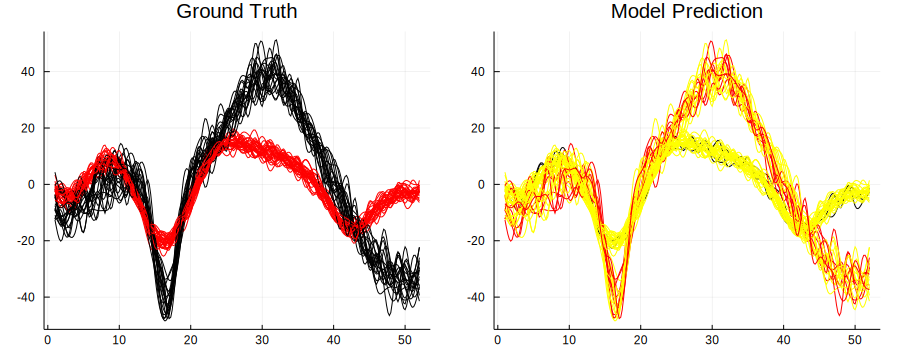

In [468]:
predict(model,shapes,unitn=2,batchsize=50)

## Save Model

In [135]:
Flux.truncate!(model)
Flux.reset!(model)
save("dnn.jld2","model",model)

In [186]:
factorial(big(128))

385620482362580421735677065923463640617493109590223590278828403276373402575165543560686168588507361534030051833058916347592172932262498857766114955245039357760034644709279247692495585280000000000000000000000000000000

In [187]:
factorial(128)

OverflowError: OverflowError: 128 is too large to look up in the table